#### DR Preprocessing Comparison
Need to figure out the best way to reduce the dimensionality of the scRNA-seq data prior to calculating EMDs for subpopulation comparison.

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [58]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.5 s, sys: 5.92 s, total: 38.4 s
Wall time: 39.5 s


In [3]:
top20 = list(range(1,21))

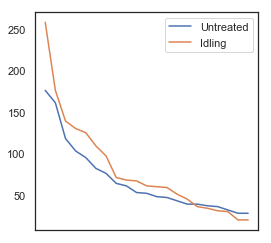

In [4]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [5]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Perform PCA on each dataset to prime DRs

In [10]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized fractional counts
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(norm='l1'), barcodes=U.barcodes, n_components=100)

CPU times: user 14.3 s, sys: 1.94 s, total: 16.2 s
Wall time: 11 s


In [11]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized fractional counts
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(norm='l1'), barcodes=I.barcodes, n_components=100)

CPU times: user 17.6 s, sys: 2.79 s, total: 20.4 s
Wall time: 14 s


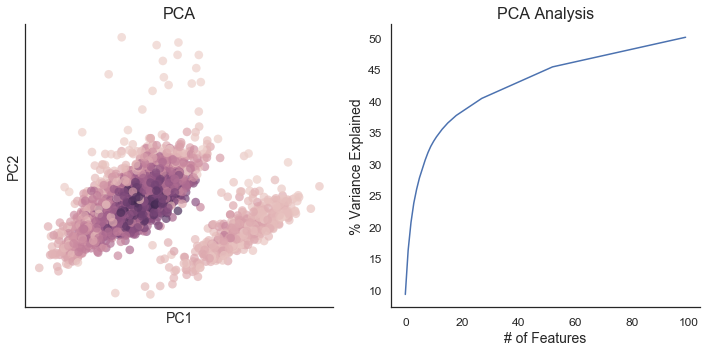

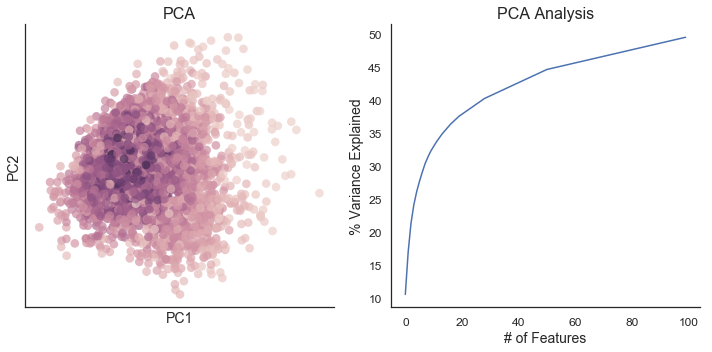

In [12]:
# visualize both PCAs
U_PCA.plot()
I_PCA.plot()

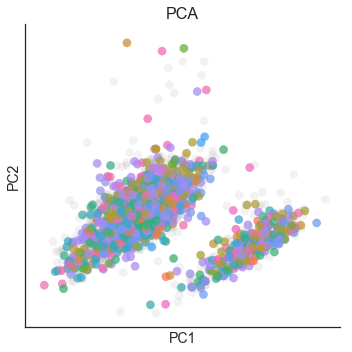

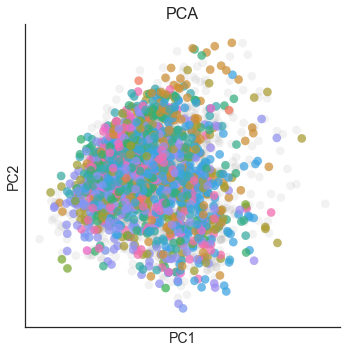

In [13]:
U_PCA.plot_barcodes(selected_codes)
I_PCA.plot_barcodes(selected_codes)

---
### t-SNE
Primed with 100-component PCA. FIt-SNE implementation.

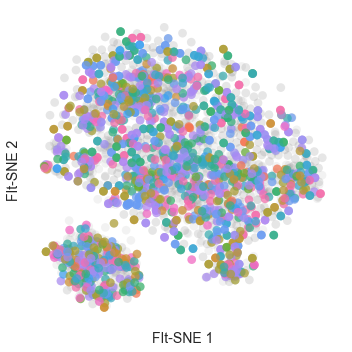

CPU times: user 1.03 s, sys: 105 ms, total: 1.14 s
Wall time: 26.2 s


In [14]:
%%time 
U_FItSNE = fcc_FItSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_FItSNE.plot_barcodes(ranks=selected_codes)

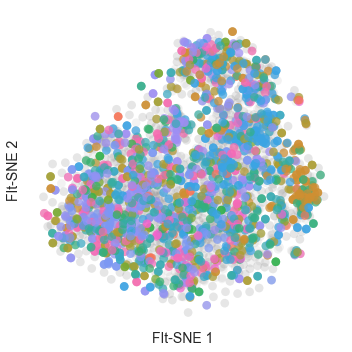

CPU times: user 1.23 s, sys: 93.5 ms, total: 1.32 s
Wall time: 30.4 s


In [15]:
%%time 
I_FItSNE = fcc_FItSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_FItSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

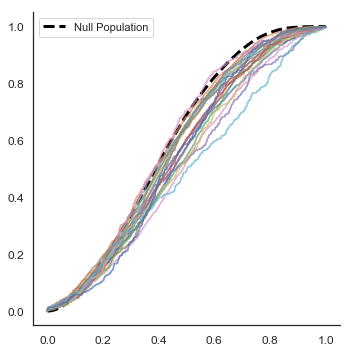

CPU times: user 32.2 s, sys: 1.11 s, total: 33.3 s
Wall time: 33.2 s


In [78]:
%%time
U_out = compare_barcode_distances(obj=U_FItSNE, barcodes=selected_codes)

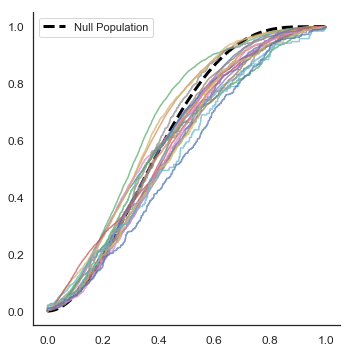

CPU times: user 50.3 s, sys: 1.72 s, total: 52 s
Wall time: 52.3 s


In [79]:
%%time
I_out = compare_barcode_distances(obj=I_FItSNE, barcodes=selected_codes)

In [73]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_FItSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min 1s, sys: 6.13 s, total: 4min 7s
Wall time: 4min 10s


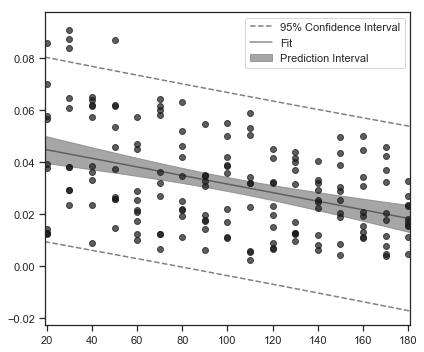

In [74]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=1)

Do the same as above for __Idling__ dataset

In [75]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_FItSNE, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 31s, sys: 16.9 s, total: 9min 48s
Wall time: 10min 36s


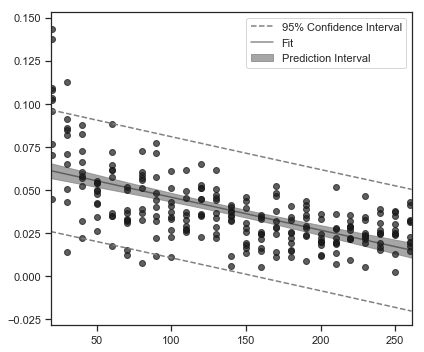

In [76]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=1)

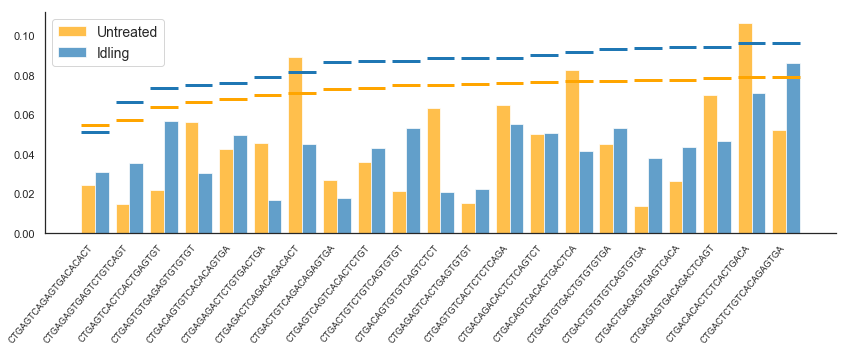

In [81]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0],
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### UMAP
Primed with 100-component PCA. 

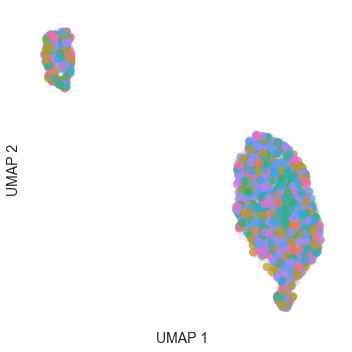

CPU times: user 13.1 s, sys: 494 ms, total: 13.6 s
Wall time: 13.4 s


In [27]:
%%time 
U_UMAP = fcc_UMAP(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_UMAP.plot_barcodes(ranks=selected_codes)

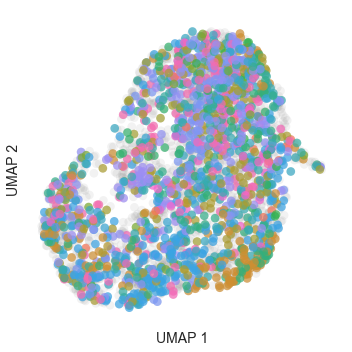

CPU times: user 9.5 s, sys: 524 ms, total: 10 s
Wall time: 9.57 s


In [28]:
%%time 
I_UMAP = fcc_UMAP(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_UMAP.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

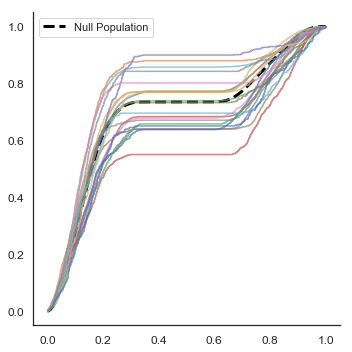

CPU times: user 32 s, sys: 1.05 s, total: 33.1 s
Wall time: 33.1 s


In [82]:
%%time
U_out_UMAP = compare_barcode_distances(obj=U_UMAP, barcodes=selected_codes)


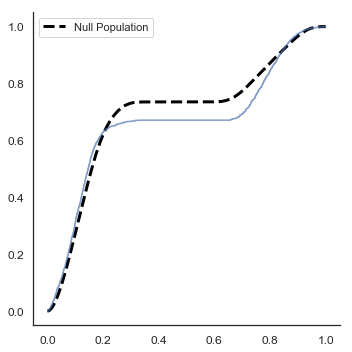

CPU times: user 2.33 s, sys: 226 ms, total: 2.56 s
Wall time: 2.35 s


,EMD,KLD,code
0,0.043543,7.66072,CTGACTGTCAGACAGAGTGA


In [30]:
%%time
compare_barcode_distances(obj=U_UMAP, barcodes=[selected_codes[7]])

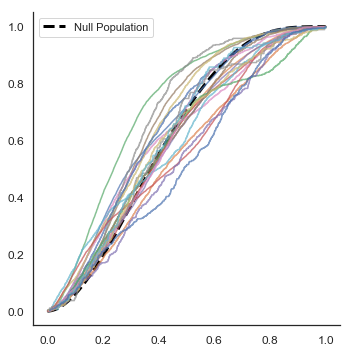

CPU times: user 49.4 s, sys: 1.55 s, total: 50.9 s
Wall time: 50.9 s


In [83]:
%%time
I_out_UMAP = compare_barcode_distances(obj=I_UMAP, barcodes=selected_codes)


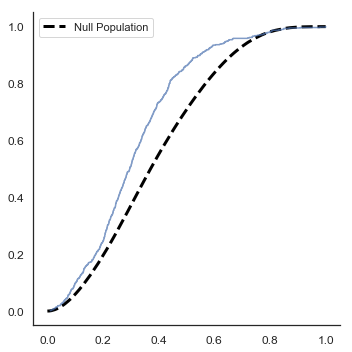

CPU times: user 3.43 s, sys: 321 ms, total: 3.75 s
Wall time: 3.52 s


,EMD,KLD,code
0,0.070584,9.211684,CTGACTGTCAGACAGAGTGA


In [32]:
%%time
compare_barcode_distances(obj=I_UMAP, barcodes=[selected_codes[7]])

In [84]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_UMAP = cell_bias_curve(obj=U_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 54s, sys: 5.93 s, total: 4min
Wall time: 4min 1s


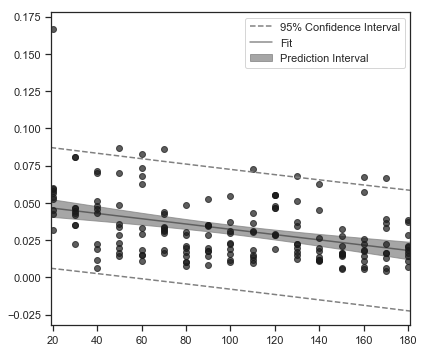

In [85]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_UMAP.melt(id_vars='n_cells')['value'], deg=1)


Do the same as above for __Idling__ dataset

In [86]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_UMAP = cell_bias_curve(obj=I_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 38s, sys: 8.26 s, total: 4min 46s
Wall time: 4min 51s


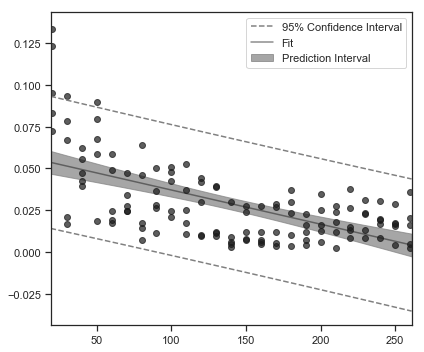

In [87]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_UMAP.melt(id_vars='n_cells')['value'], deg=1)


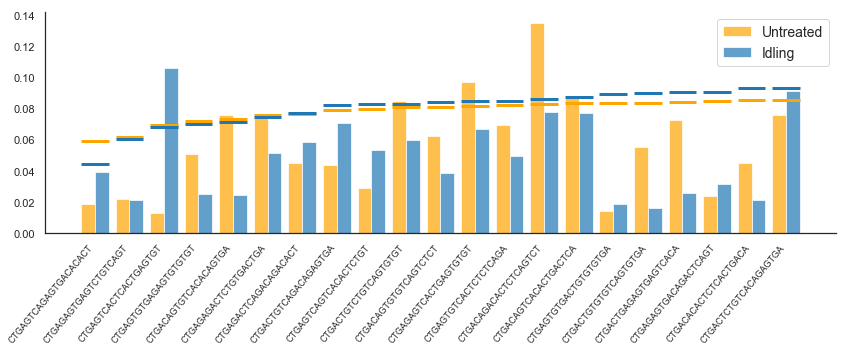

In [88]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out_UMAP.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out_UMAP.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_UMAP.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_UMAP.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### DCA
Feature selection using DCA

In [50]:
%time U_DCA = fcc_DCA(matrix=U.counts, barcodes=U.barcodes, norm='arcsinh')


DCA: Successfully preprocessed 17172 genes and 2886 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 23min 5s, sys: 5min 23s, total: 28min 29s
Wall time: 13min 32s


In [51]:
%time I_DCA = fcc_DCA(matrix=I.counts, barcodes=I.barcodes, norm='arcsinh')

DCA: Successfully preprocessed 17193 genes and 3524 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 37min 48s, sys: 7min 58s, total: 45min 47s
Wall time: 22min 59s


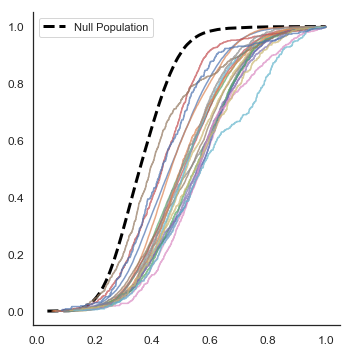

CPU times: user 7min 35s, sys: 6min 3s, total: 13min 38s
Wall time: 13min 41s


In [52]:
%%time
U_out = compare_barcode_distances(obj=U_DCA, barcodes=selected_codes)

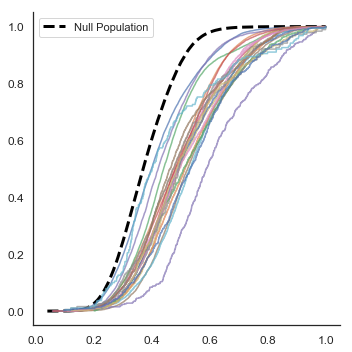

CPU times: user 11min 17s, sys: 8min 58s, total: 20min 16s
Wall time: 20min 20s


In [53]:
%%time
I_out = compare_barcode_distances(obj=I_DCA, barcodes=selected_codes)

In [54]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_DCA, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 11min 48s, sys: 6min 29s, total: 18min 17s
Wall time: 18min 21s


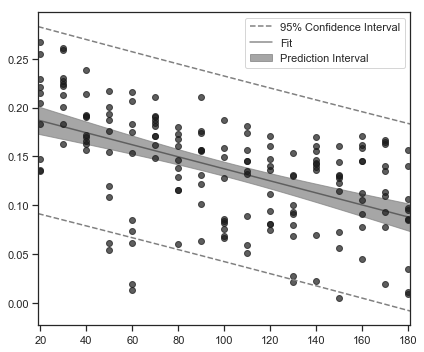

In [55]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=1)

Do the same as above for __Idling__ dataset

In [56]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_DCA, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 17min 37s, sys: 10min 37s, total: 28min 15s
Wall time: 28min 26s


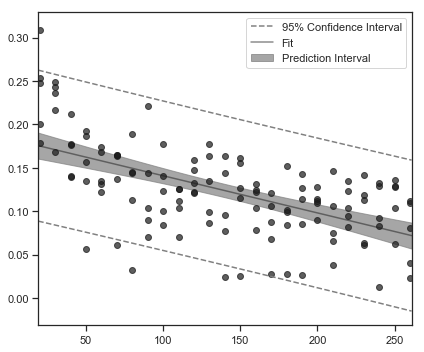

In [57]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=1)

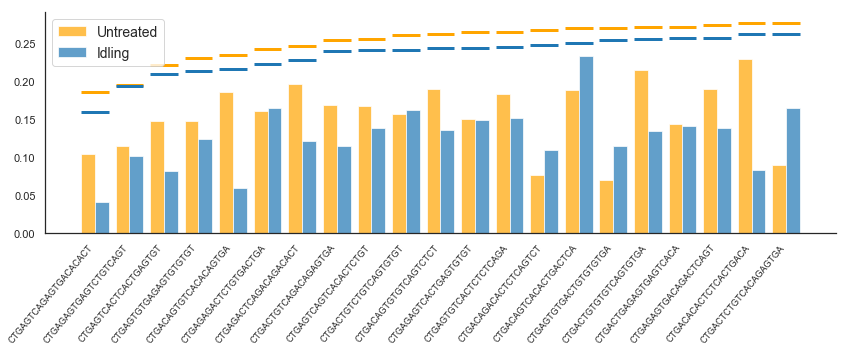

In [58]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()